## This notebook uses the new data selection framework to build a batter runs inferential model which incorporates batter, bowler, venue, over, innings and strike rate information

### It permits the following data selection options:

- For a given (tournament,season) tuple i.e the test_tournament and the test_season
- The test data set includes all balls bowled in the test season
- The training data set is chosen based on the following options:
    - or_selection: All balls from all tournaments before this season which featured one of the venues, batters or bowlers who is playing the test season
    - and_selection: All balls from all tournaments before this sesions which featured a venue, batter and bowler who is playing the test season
    
    
### The notebook loads the trained model from disk and enables exploration of the model results

### This notebook is executed for the "and_selection" for the IPL 2009 test season. The training dataset has 1.8k balls.

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from IPython.display import Image

# import jupyter_black
# jupyter_black.load()

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

np.set_printoptions(2)

# filter out Seaborn UserWarnings
warnings.filterwarnings(action="ignore", category=UserWarning, module=r"seaborn")
# warnings.filterwarnings(action="ignore", category=RuntimeWarning, module=r"scipy")
from warnings import simplefilter, warn

simplefilter("ignore")

In [2]:
import os
os.getcwd()

'/Users/gireeshramji/PycharmProjects/SouthridgeCorp/player-outcome-predictor/notebooks'

In [3]:
os.chdir("..")
os.getcwd()

'/Users/gireeshramji/PycharmProjects/SouthridgeCorp/player-outcome-predictor'

In [4]:
from utils.config_utils import ConfigUtils
from historical_data.singleton import Helper
from data_selection.data_selection import DataSelection
from rewards_configuration.rewards_configuration import RewardsConfiguration
from simulators.perfect_simulator import PerfectSimulator

In [5]:
import aesara.tensor as at

In [6]:
config_utils = ConfigUtils(".streamlit/config.toml")
helper = Helper(config_utils)
data_selection = DataSelection(helper)
rewards_config = RewardsConfiguration(config_utils)
perfect_simulator = PerfectSimulator(data_selection, rewards_config)

2022-11-18 13:54:10.447 INFO    root: Creating feedback form storage with method local


In [7]:
helper.tournaments.df

,key,name,first_match_date,last_match_date
0,t20s,International T20s,2005-02-17,2022-10-05
1,apl,Afghanistan Premier League,2018-10-05,2018-10-21
2,bbl,Big Bash League,2011-12-16,2022-01-28
3,bpl,Bangladesh Premier League,2012-02-11,2022-02-18
4,cpl,Caribbean Premier League,2013-07-30,2022-09-30
5,ctc,CSA T20 Challenge,2012-02-15,2022-02-27
6,ipl,Indian Premier League,2008-04-18,2022-05-29
7,lpl,Lanka Premier League,2020-11-26,2021-12-23
8,psl,Pakistan Super League,2016-02-04,2022-02-27
9,ssm,Super Smash,2013-01-20,2022-01-29


In [8]:
selected_tournament = 'Indian Premier League'
tournament_start_date = helper.tournaments.df.query(f'name == "{selected_tournament}"').first_match_date.iloc[0]
tournament_end_date = helper.tournaments.df.query(f'name == "{selected_tournament}"').last_match_date.iloc[0]

In [9]:
helper.tournaments.set_selected_tournament_names([selected_tournament])
helper.tournaments.set_start_end_dates(tournament_start_date, tournament_end_date, False)

In [10]:
helper.tournaments.get_selected_tournaments()

['ipl']

In [11]:
helper.tournaments.get_start_end_dates(False)

(datetime.date(2008, 4, 18), datetime.date(2022, 5, 29))

In [12]:
all_matches_for_tournament = data_selection.get_selected_matches(False)

In [13]:
all_bowling_outcomes_for_tournament = perfect_simulator.get_bowling_outcomes_by_ball_and_innings(False)
all_match_states_for_tournament = perfect_simulator.get_match_state_by_ball_and_innings(False)

In [14]:
all_matches_for_tournament.season.value_counts()

2013       76
2012       74
2022       74
2011       73
2021       60
2019       60
2016       60
2014       60
2020/21    60
2018       60
2009/10    60
2015       59
2017       59
2007/08    58
2009       57
Name: season, dtype: int64

In [15]:
test_season = '2009'

In [16]:
test_season_matches = all_matches_for_tournament.query(f'season == "{test_season}"')

In [17]:
test_start_date = test_season_matches.date.min()
test_end_date = test_season_matches.date.max()

In [18]:
(test_start_date,test_end_date)

(datetime.date(2009, 4, 18), datetime.date(2009, 5, 24))

In [19]:
test_season_venues = test_season_matches.venue.unique().tolist()
test_season_match_keys = test_season_matches.key.unique().tolist()

In [20]:
test_season_match_state_df = all_match_states_for_tournament.query('match_key in @test_season_match_keys')
test_season_bowling_outcomes_df = all_bowling_outcomes_for_tournament.query('match_key in @test_season_match_keys')

In [21]:
test_season_batters = test_season_match_state_df.batter.unique().tolist()
test_season_bowlers = test_season_match_state_df.bowler.unique().tolist()

In [22]:
previous_season = '2007/08'
previous_season_matches = all_matches_for_tournament.query(f'season == "{previous_season}"')
previous_season_end_date = previous_season_matches.date.max()

In [23]:
previous_season_end_date

datetime.date(2008, 6, 1)

In [24]:
#Now we know all the batters, bowlers and venues that we need to query for training data.
#So we choose all tournaments and set the training window to precede the test window
helper.tournaments.set_selected_tournament_names(helper.tournaments.df.name.tolist())
helper.tournaments.set_start_end_dates(helper.tournaments.df.first_match_date.min(), 
                                       test_start_date, 
                                       False)


In [25]:
helper.tournaments.get_selected_tournaments()

['t20s',
 'apl',
 'bbl',
 'bpl',
 'cpl',
 'ctc',
 'ipl',
 'lpl',
 'psl',
 'ssm',
 'ntb',
 'msl']

In [26]:
helper.tournaments.get_start_end_dates(False)

(datetime.date(2005, 2, 17), datetime.date(2009, 4, 18))

In [27]:
helper.tournaments.get_start_end_dates(True)

(datetime.date(2005, 2, 17), datetime.date(2022, 10, 5))

In [28]:
am = data_selection.get_selected_matches(False)

In [29]:
(am.date.min(),am.date.max())

(datetime.date(2005, 2, 17), datetime.date(2009, 4, 18))

In [30]:
unqualified_train_bowling_outcomes_df = perfect_simulator.get_bowling_outcomes_by_ball_and_innings(False)
unqualified_train_match_state_df = perfect_simulator.get_match_state_by_ball_and_innings(False)

In [31]:
unqualified_train_bowling_outcomes_df.shape

(30550, 20)

In [32]:
is_test_season_venue = unqualified_train_match_state_df.venue.isin(test_season_venues)
is_test_season_batter = unqualified_train_match_state_df.batter.isin(test_season_batters)
is_test_season_bowler = unqualified_train_match_state_df.bowler.isin(test_season_bowlers)

In [33]:
selection_options = {
    'or_selection' : is_test_season_venue | is_test_season_batter | is_test_season_bowler,
    'and_selection' : is_test_season_venue & is_test_season_batter & is_test_season_bowler
}

In [70]:
selection = 'and_selection'

In [71]:
train_match_state_df = unqualified_train_match_state_df.loc[selection_options[selection]]
train_bowling_outcomes_df = unqualified_train_bowling_outcomes_df.loc[selection_options[selection]]

In [72]:
frequent_players_set = set(test_season_batters + test_season_bowlers)

In [73]:
train_match_state_df.shape

(1771, 611)

In [74]:
train_match_state_df.query('bowler in @test_season_bowlers').shape

(1771, 611)

In [75]:
train_bowlers = train_match_state_df.bowler.unique().tolist()
train_batters= train_match_state_df.batter.unique().tolist()

In [76]:
len(set(test_season_bowlers).intersection(train_bowlers))/len(test_season_bowlers)

0.42857142857142855

In [77]:
len(set(test_season_batters).intersection(train_batters))/len(test_season_batters)

0.4666666666666667

In [78]:
test_season_match_state_df.query('batter in @train_batters').shape

(10057, 426)

In [79]:
test_season_match_state_df.query('bowler in @train_bowlers').shape

(6660, 426)

In [80]:
test_season_match_state_df.shape

(13606, 426)

## Building new features and targets

In [81]:
def batter_featured_id(df):
    c1 = df['batter'].isin(frequent_players_set)
    df.loc[c1,'batter_featured_id'] = df['batter']
    df['batter_featured_id'].fillna('non_frequent_player',inplace=True)
    
def bowler_featured_id(df):
    c1 = df['batter'].isin(frequent_players_set)
    df.loc[c1,'bowler_featured_id'] = df['bowler']
    df['bowler_featured_id'].fillna('non_frequent_player',inplace=True)
    
def is_legal_delivery(df):
    c1 = df.noballs.isna() 
    c2 = df.wides.isna()
    df.loc[c1&c2,'is_legal_delivery'] = True
    df['is_legal_delivery'].fillna(False,inplace=True)
    
def striker_dismissed(df):
    c1 = (df['batter'] == df['player_dismissed'])
    c2 = (df['player_dismissed'].isna()==False)
    df.loc[c1&c2,'striker_dismissed'] = True
    c3 = (df['batter'] != df['player_dismissed'])
    df.loc[c3 & c2,'striker_dismissed'] = False

def innings_strike_rate(df):
    df['innings_strike_rate'] = df['current_total']/df['total_balls_bowled']
    df['innings_strike_rate'].fillna(0,inplace=True)
    max_value = np.nanmax(df[['innings_strike_rate']][df['innings_strike_rate'] != np.inf])
    df['innings_strike_rate'].replace([np.inf, -np.inf], max_value, inplace=True)

    
def add_column_to_df(df,
                     column_name):
    column_name(df)

In [82]:
for df in [train_match_state_df,
           test_season_match_state_df]:
    for column in [batter_featured_id,
                   bowler_featured_id,
                   innings_strike_rate]:
        add_column_to_df(df,
                         column)

In [83]:
for df in [train_bowling_outcomes_df,
           test_season_bowling_outcomes_df]:
    for column in [is_legal_delivery,
                   striker_dismissed]:
        add_column_to_df(df,
                         column)

In [84]:
for df in [train_match_state_df,
           test_season_match_state_df,
           train_bowling_outcomes_df,
           test_season_bowling_outcomes_df]:
    df.reset_index(inplace=True)

In [85]:
train_match_state_df.innings_strike_rate.max()

5.0

## Building Categoricals for Indexing

In [86]:
def build_categoricals_for_column(df,column):
    categorical = pd.Categorical(df[column])
    return categorical.categories
    
def get_categorical_column_index_for_df(df,
                            categories,
                            column):
    idx = pd.Categorical(df[column],
                         categories).codes
    return idx

In [87]:
COORDS = {}
train_feature_data = {}
test_feature_data = {}
all_feature_data = {}
for dim in ['batter_featured_id',
            'bowler_featured_id',
            'batting_team',
            'bowling_team',
            'venue',
            'wickets_fallen',
            'over',
            'match_key',
            'inning',
            'ball']:
    categories = build_categoricals_for_column(test_season_match_state_df,
                                               dim)
    COORDS[dim] = categories
    train_feature_data[dim] = get_categorical_column_index_for_df(train_match_state_df,
                                                                  categories,
                                                                  dim)
    test_feature_data[dim] = get_categorical_column_index_for_df(test_season_match_state_df,
                                                              categories,
                                                              dim)

In [88]:
for dim in ['innings_strike_rate']:
    train_feature_data[dim] = train_match_state_df[dim]
    test_feature_data[dim] = test_season_match_state_df[dim]

In [89]:
train_outcome_data = {}
test_outcome_data = {}
all_outcome_data = {}
for dim in ['batter_runs',
            'extras',
            'is_legal_delivery',
            'is_wicket',
            'wides',
            'noballs',
            'dismissal_kind',
            'is_direct_runout']:
    categories = build_categoricals_for_column(train_bowling_outcomes_df,
                                               dim)
    COORDS[dim] = categories
    train_outcome_data[dim] = get_categorical_column_index_for_df(train_bowling_outcomes_df,
                                                                  categories,
                                                                  dim)
    test_outcome_data[dim] = get_categorical_column_index_for_df(test_season_bowling_outcomes_df,
                                                              categories,
                                                              dim)

In [90]:
COORDS

{'batter_featured_id': Index(['AAr1948', 'ABa3507', 'ACa3489', 'ADa1260', 'AFf997', 'AGh3600',
        'AGt990', 'AKe3514', 'AMa1185', 'AMd2912',
        ...
        'WMa3611', 'WSa3464', 'WVs1108', 'YNr3492', 'YPn1126', 'YSh3488',
        'YSh604', 'YTe3551', 'YVRo3456', 'ZKn743'],
       dtype='object', length=150),
 'bowler_featured_id': Index(['AAr1948', 'ADa1260', 'AFf997', 'AKe3514', 'AMa1185', 'AMd2912',
        'AMn3593', 'AMs106', 'AMs1940', 'ANa722',
        ...
        'VSg740', 'VSh3447', 'WMa3611', 'WVs1108', 'YAa2294', 'YNr3492',
        'YPn1126', 'YSh604', 'YVRo3456', 'ZKn743'],
       dtype='object', length=112),
 'batting_team': Index(['Chennai Super Kings', 'Deccan Chargers', 'Delhi Daredevils',
        'Kings XI Punjab', 'Kolkata Knight Riders', 'Mumbai Indians',
        'Rajasthan Royals', 'Royal Challengers Bangalore'],
       dtype='object'),
 'bowling_team': Index(['Chennai Super Kings', 'Deccan Chargers', 'Delhi Daredevils',
        'Kings XI Punjab', 'Kolkata 

In [91]:
train_feature_data

{'batter_featured_id': array([125, 125, 125, ...,  55,  55,  55], dtype=int16),
 'bowler_featured_id': array([22, 22, 22, ..., 43, 43,  3], dtype=int8),
 'batting_team': array([-1, -1, -1, ...,  6,  6,  6], dtype=int8),
 'bowling_team': array([-1, -1, -1, ...,  7,  7,  7], dtype=int8),
 'venue': array([3, 3, 3, ..., 4, 4, 4], dtype=int8),
 'wickets_fallen': array([ 3,  3,  3, ...,  9,  9, 10], dtype=int8),
 'over': array([ 6,  6,  6, ..., 14, 14, 15], dtype=int8),
 'match_key': array([-1, -1, -1, ...,  1,  1,  1], dtype=int8),
 'inning': array([1, 1, 1, ..., 1, 1, 1], dtype=int8),
 'ball': array([3, 4, 7, ..., 4, 5, 0], dtype=int8),
 'innings_strike_rate': 0       1.175000
 1       1.170732
 2       1.204545
 3       1.037037
 4       1.024390
           ...   
 1766    0.585106
 1767    0.578947
 1768    0.593750
 1769    0.597938
 1770    0.591837
 Name: innings_strike_rate, Length: 1771, dtype: float64}

In [92]:
test_feature_data

{'batter_featured_id': array([117, 127, 127, ..., 105, 105, 105], dtype=int16),
 'bowler_featured_id': array([54, 54, 54, ..., 77, 77, 77], dtype=int8),
 'batting_team': array([5, 5, 5, ..., 7, 7, 7], dtype=int8),
 'bowling_team': array([0, 0, 0, ..., 1, 1, 1], dtype=int8),
 'venue': array([4, 4, 4, ..., 3, 3, 3], dtype=int8),
 'wickets_fallen': array([0, 0, 0, ..., 9, 9, 9], dtype=int8),
 'over': array([ 0,  0,  0, ..., 19, 19, 19], dtype=int8),
 'match_key': array([ 0,  0,  0, ..., 56, 56, 56], dtype=int8),
 'inning': array([0, 0, 0, ..., 1, 1, 1], dtype=int8),
 'ball': array([0, 1, 2, ..., 3, 4, 5], dtype=int8),
 'innings_strike_rate': 0        8.000000
 1        1.000000
 2        0.500000
 3        0.666667
 4        0.500000
            ...   
 13601    1.120690
 13602    1.111111
 13603    1.118644
 13604    1.142857
 13605    1.141667
 Name: innings_strike_rate, Length: 13606, dtype: float64}

In [93]:
def build_xarray(feature_dict,
                 outcome_dict,
                 index_df):
    feature_df = pd.DataFrame(feature_dict)
    feature_df.index = index_df.index
    outcome_df = pd.DataFrame(outcome_dict)
    outcome_df.index = index_df.index
    combined_df = pd.merge(outcome_df,
                           feature_df,
                           left_index = True,
                           right_index = True)
    return combined_df, combined_df.to_xarray()

In [94]:
train_combined_df,train_combined_xarray = build_xarray(train_feature_data,
                                                         train_outcome_data,
                                                         train_match_state_df)

In [95]:
test_combined_df,test_combined_xarray = build_xarray(test_feature_data,
                                                         test_outcome_data,
                                                         test_season_match_state_df)

<AxesSubplot: xlabel='innings_strike_rate', ylabel='batter_runs'>

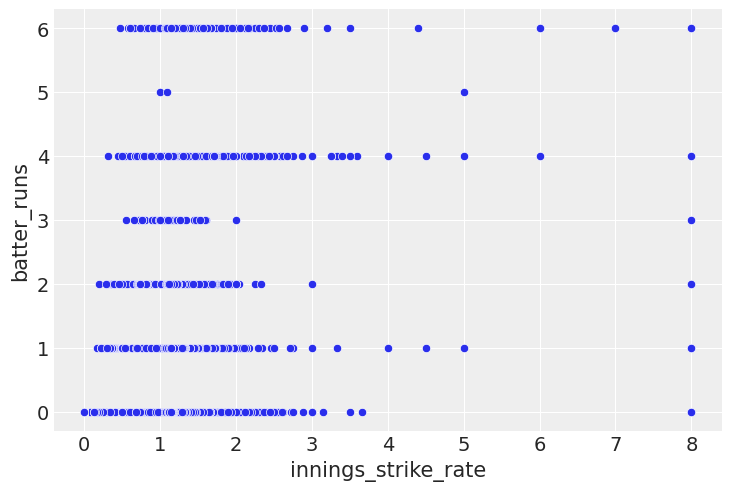

In [96]:
sns.scatterplot(
    data = test_combined_df,
    x = 'innings_strike_rate',
    y = 'batter_runs'
)

<AxesSubplot: xlabel='wickets_fallen', ylabel='innings_strike_rate'>

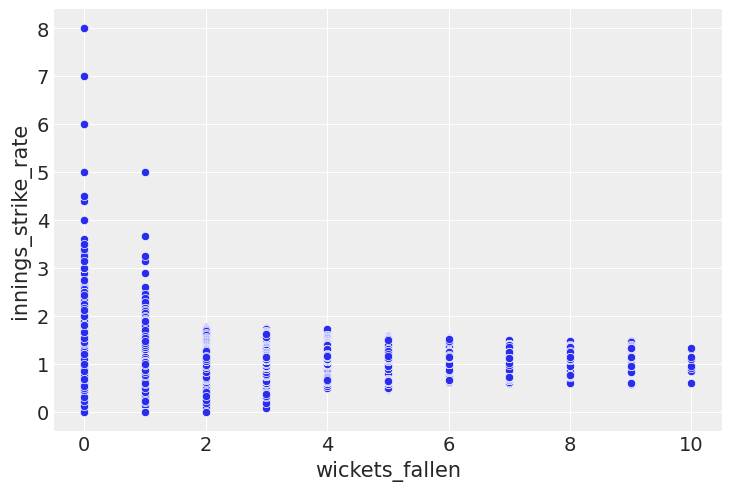

In [97]:
sns.scatterplot(
    data = test_combined_df,
    x = 'wickets_fallen',
    y = 'innings_strike_rate'
)

<AxesSubplot: xlabel='is_wicket', ylabel='innings_strike_rate'>

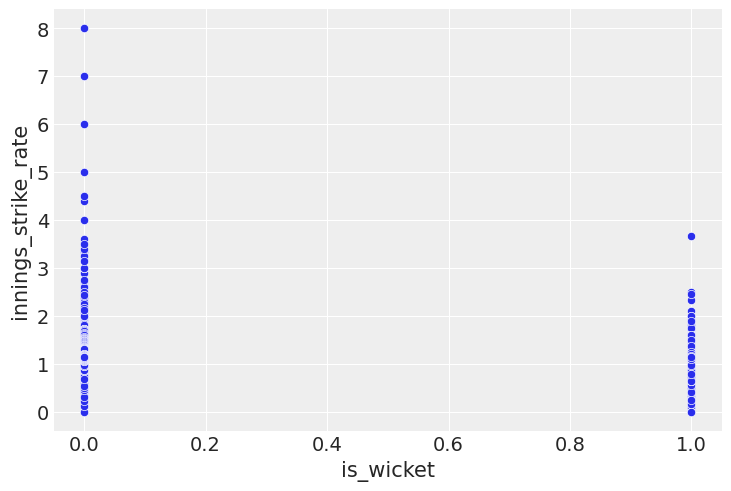

In [98]:
sns.scatterplot(
    data = test_combined_df,
    x = 'is_wicket',
    y = 'innings_strike_rate'
)

## Adding Data to the PyMC Model

In [99]:
with pm.Model(coords=COORDS) as batter_runs_model:
    batter_runs_model.add_coord('ball_ids',
                                   values = np.arange(train_combined_df.shape[0]),
                                   mutable = True)
    is_legal_delivery_outcomes_data = pm.MutableData("is_legal_delivery_outcomes_data",
                                                     train_combined_df['is_legal_delivery'],
                                                     dims = 'ball_ids')
    batter_runs_outcomes_data = pm.MutableData("batter_runs_outcomes_data",
                                               train_combined_df['batter_runs'],
                                               dims = 'ball_ids')
    batter_featured_id_feature_data = pm.MutableData("batter_featured_id_feature_data",
                                                     train_combined_df['batter_featured_id'],
                                                     dims = 'ball_ids')
    bowler_featured_id_feature_data = pm.MutableData("bowler_featured_id_feature_data",
                                                 train_combined_df['bowler_featured_id'],
                                                 dims = 'ball_ids')
    venue_feature_data = pm.MutableData("venue_feature_data",
                                        train_combined_df['venue'],
                                        dims = 'ball_ids')
    batting_team_feature_data = pm.MutableData("batting_team_feature_data",
                                    train_combined_df['batting_team'],
                                    dims = 'ball_ids')
    bowling_team_feature_data = pm.MutableData("bowling_team_feature_data",
                                    train_combined_df['bowling_team'],
                                    dims = 'ball_ids')
    over_feature_data = pm.MutableData("over_feature_data",
                                    train_combined_df['over'],
                                    dims = 'ball_ids')
    inning_feature_data = pm.MutableData("inning_feature_data",
                                    train_combined_df['inning'],
                                    dims = 'ball_ids')
    wickets_fallen_feature_data = pm.MutableData("wickets_fallen_feature_data",
                                train_combined_df['wickets_fallen'],
                                dims = 'ball_ids')
    is_wicket_outcome_data = pm.MutableData("is_wicket_outcome_data",
                                train_combined_df['is_wicket'],
                                dims = 'ball_ids')
    is_legal_delivery_outcome_data = pm.MutableData("is_legal_delivery_outcome_data",
                            train_combined_df['is_legal_delivery'],
                            dims = 'ball_ids')
    innings_strike_rate_feature_data = pm.MutableData("innings_strike_rate_feature_data",
                            train_combined_df[['innings_strike_rate']].values)

In [100]:
import pickle

def save_model(trace, model_name):
    with open (f'data/models/{model_name}', 'wb') as buff:
        pickle.dump ({'trace': trace}, buff)

def load_model(model_name):
    with open (f'data/models/{model_name}', 'rb') as buff:
        data = pickle.load (buff)
    idata = data['trace']
    return idata

In [101]:
model_name = f'{selected_tournament}_{test_season}_{selection}_with_SR.pkl'

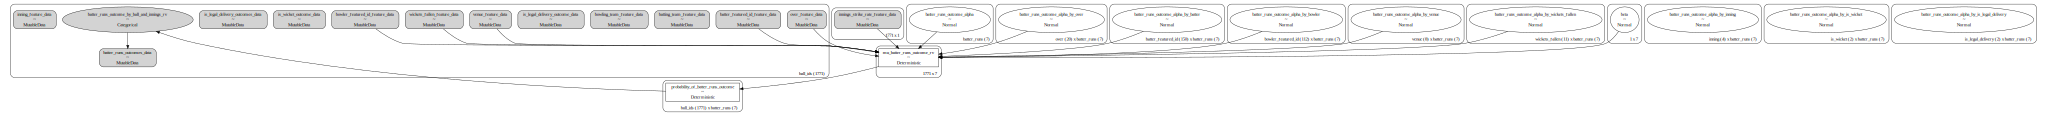

In [102]:
with batter_runs_model:
    batter_runs_outcome_alpha = pm.Normal('batter_runs_outcome_alpha',
                                         mu=0,
                                         sigma=3,
                                         dims='batter_runs')
    batter_runs_outcome_alpha_by_over = pm.Normal('batter_runs_outcome_alpha_by_over',
                                                mu = 0,
                                                sigma = 3.0,
                                                dims = ('over',
                                                        'batter_runs'))
    batter_runs_outcome_alpha_mu_by_batter_global = 0
    batter_runs_outcome_alpha_sigma_by_batter_global = 3.0
    batter_runs_outcome_alpha_by_batter = pm.Normal('batter_runs_outcome_alpha_by_batter',
                                                    mu = batter_runs_outcome_alpha_mu_by_batter_global,
                                                    sigma = batter_runs_outcome_alpha_sigma_by_batter_global,
                                                    dims = ('batter_featured_id',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_inning = pm.Normal('batter_runs_outcome_alpha_by_inning',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('inning',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_bowler = pm.Normal('batter_runs_outcome_alpha_by_bowler',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('bowler_featured_id',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_venue = pm.Normal('batter_runs_outcome_alpha_by_venue',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('venue',
                                                            'batter_runs'))

    batter_runs_outcome_alpha_by_wickets_fallen = pm.Normal('batter_runs_outcome_alpha_by_wickets_fallen',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('wickets_fallen',
                                                            'batter_runs'))
    batter_runs_outcome_beta_by_innings_strike_rate = pm.Normal("beta", 
                                                                mu = 0,
                                                                sigma = 1,
                                                                shape = (1,
                                                                         COORDS['batter_runs'].shape[0]))
    batter_runs_outcome_alpha_by_is_wicket = pm.Normal('batter_runs_outcome_alpha_by_is_wicket',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('is_wicket',
                                                            'batter_runs'))
    batter_runs_outcome_alpha_by_is_legal_delivery = pm.Normal('batter_runs_outcome_alpha_by_is_legal_delivery',
                                                    mu = 0,
                                                    sigma = 3.0,
                                                    dims = ('is_legal_delivery',
                                                            'batter_runs'))
    batter_runs_outcome_mu = pm.Deterministic('mu_batter_runs_outcome_rv',
                                                        batter_runs_outcome_alpha+
                                                        batter_runs_outcome_alpha_by_batter[batter_featured_id_feature_data]+
                                                        batter_runs_outcome_alpha_by_bowler[bowler_featured_id_feature_data]+
                                                        batter_runs_outcome_alpha_by_over[over_feature_data]+
                                                        batter_runs_outcome_alpha_by_wickets_fallen[wickets_fallen_feature_data]+
                                                        #batter_runs_outcome_alpha_by_is_wicket[is_wicket_outcome_data]+
                                                        #batter_runs_outcome_alpha_by_is_legal_delivery[is_legal_delivery_outcome_data]+
                                                        batter_runs_outcome_beta_by_innings_strike_rate*innings_strike_rate_feature_data+
                                                        batter_runs_outcome_alpha_by_venue[venue_feature_data])
    probability_of_batter_runs_outcome_rv = pm.Deterministic('probability_of_batter_runs_outcome',
                                                         at.nnet.softmax(batter_runs_outcome_mu),
                                                         dims = ('ball_ids','batter_runs'))
    batter_outcomes_by_ball_and_innings_rv = pm.Categorical('batter_runs_outcome_by_ball_and_innings_rv',
                                                         p=probability_of_batter_runs_outcome_rv,
                                                         observed=batter_runs_outcomes_data,
                                                         dims = 'ball_ids')

pm.model_to_graphviz(batter_runs_model)

In [103]:
idata_loaded = load_model(model_name)

## Model belief in batter runs probabilities over all balls in the training dataset

array([[<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n0'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n1'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n2'}>],
       [<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n3'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n4'}>,
        <AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n5'}>],
       [<AxesSubplot: title={'center': 'probability_of_batter_runs_outcome\n6'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

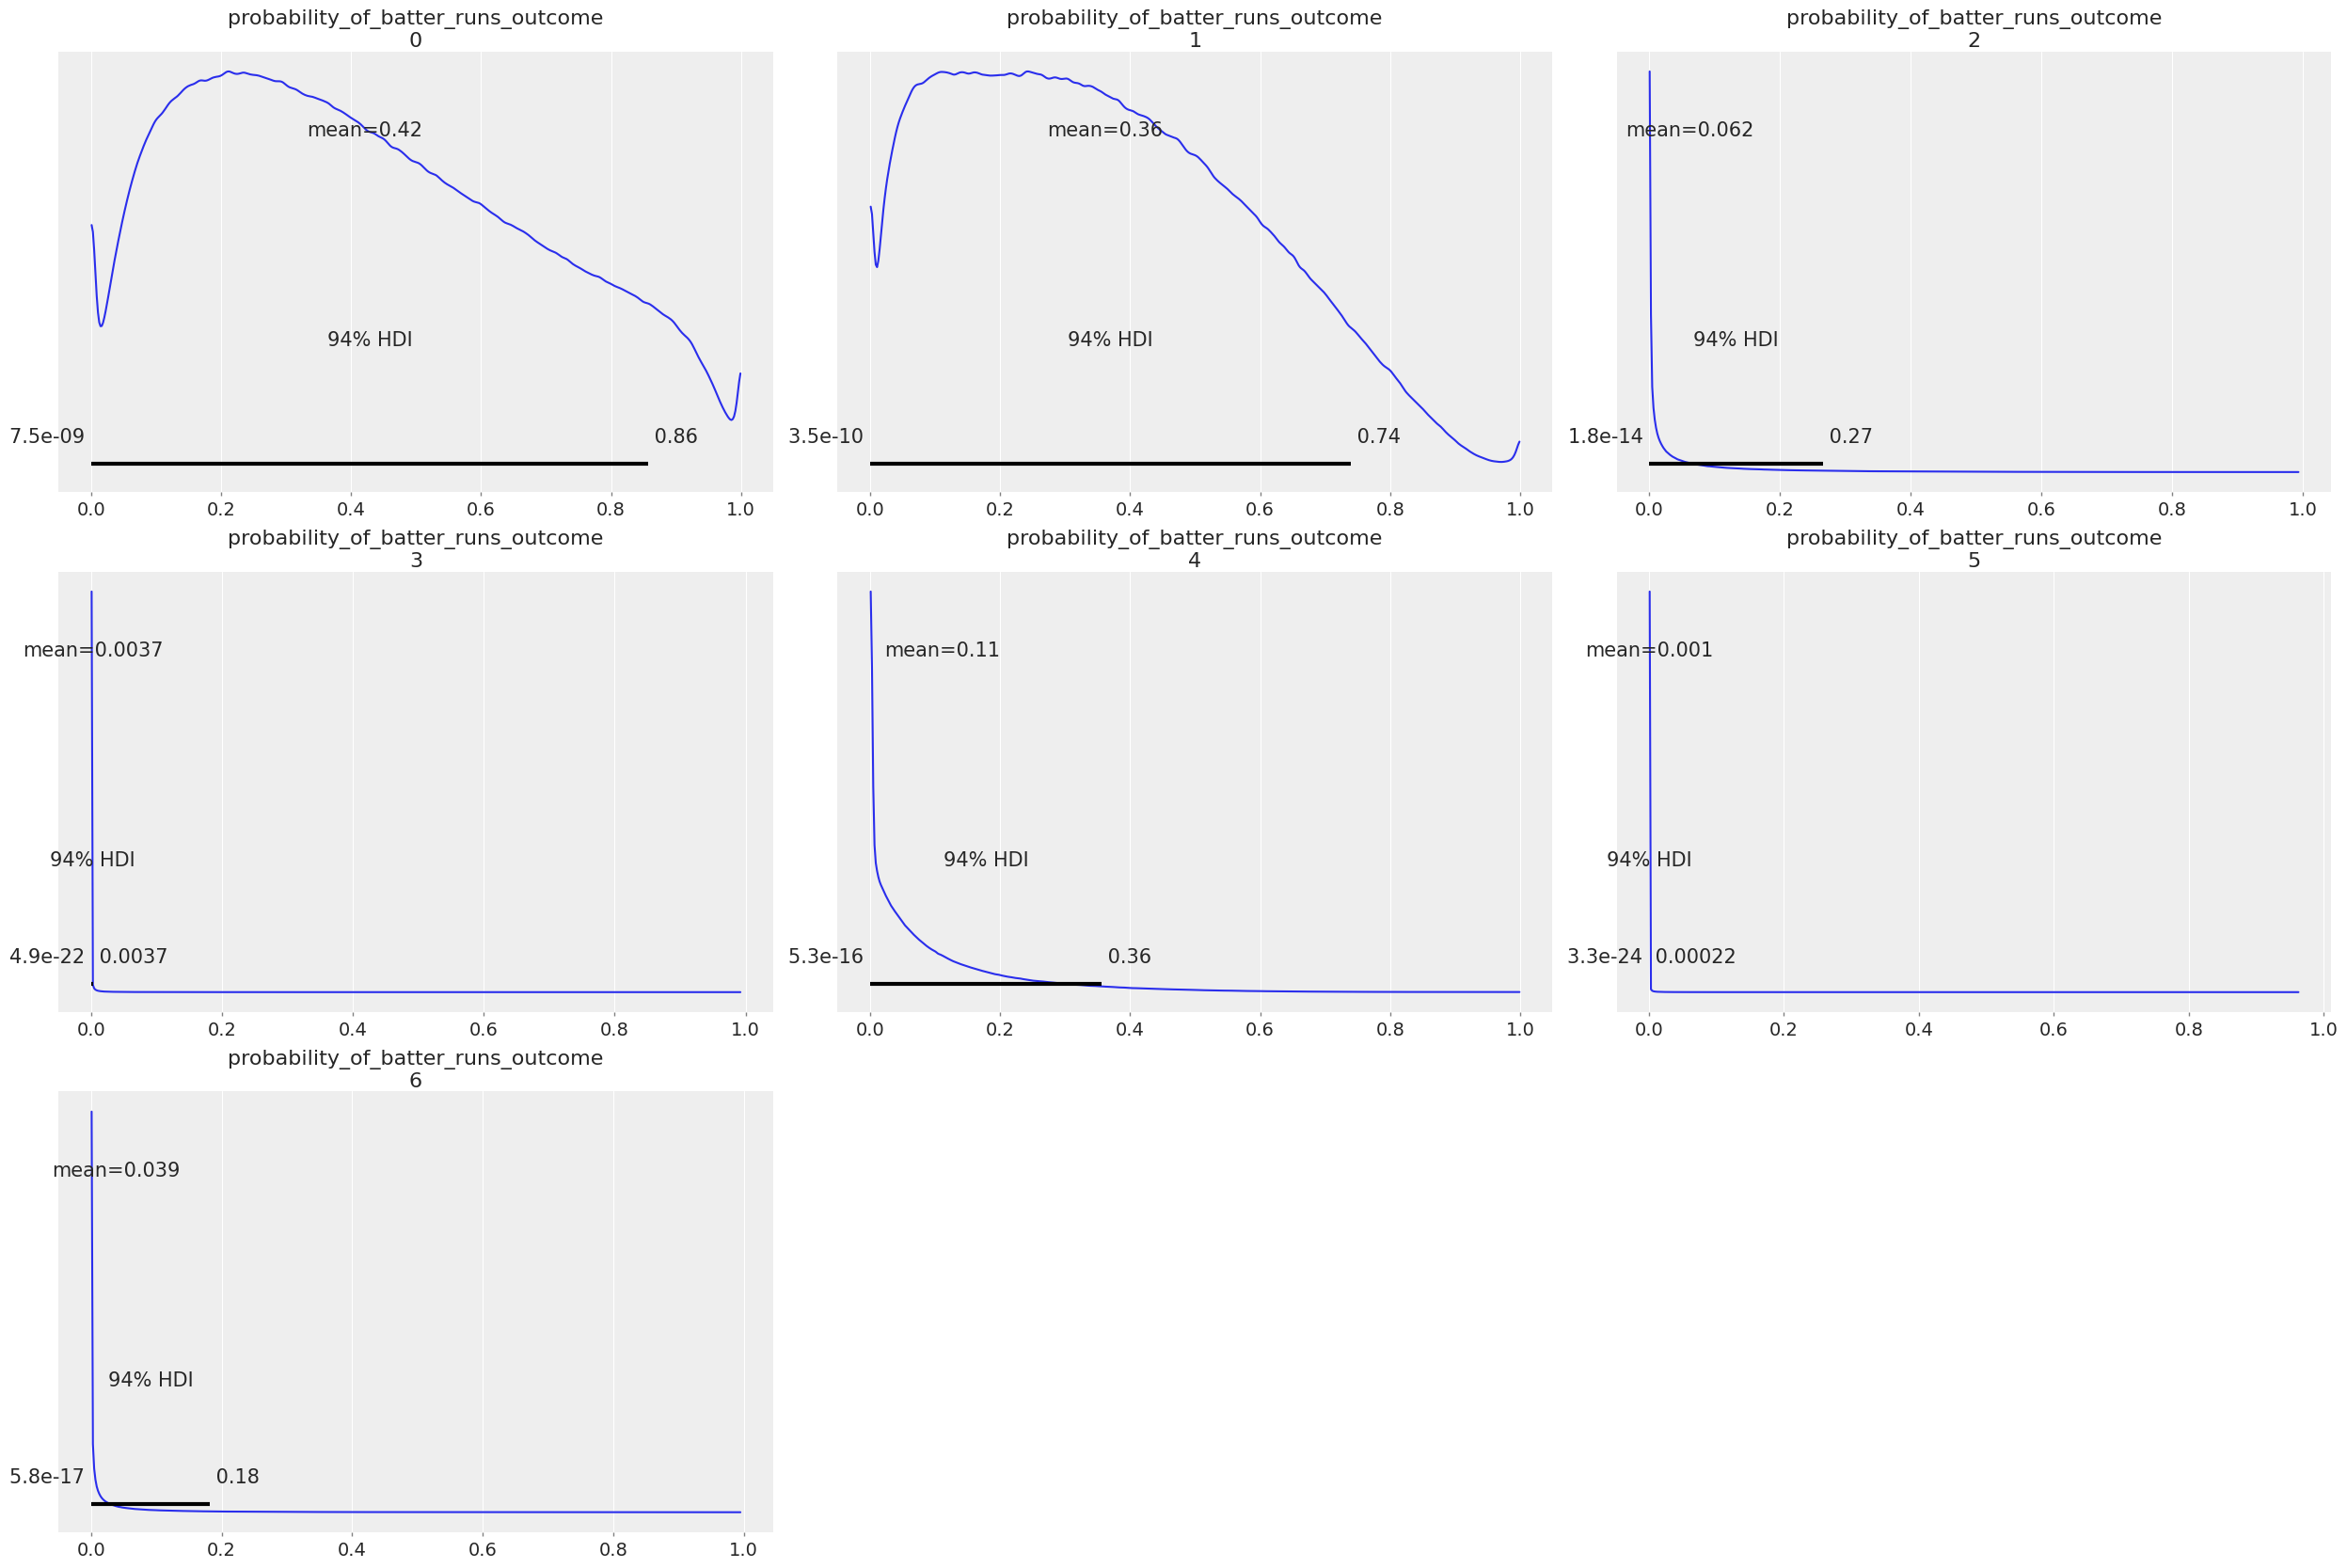

In [104]:
az.plot_posterior(idata_loaded.posterior,
                  var_names = ['probability_of_batter_runs_outcome'],
                  combine_dims = {'chain','draw','ball_ids'})

In [105]:
az.summary(idata_loaded.posterior,
           var_names = ['batter_runs_outcome_alpha',
                        'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
batter_runs_outcome_alpha[0],5.519,1.955,1.826,9.065,0.056,0.041,1202.0,1866.0,1.0
batter_runs_outcome_alpha[1],3.396,1.946,-0.324,6.969,0.056,0.039,1217.0,2193.0,1.0
batter_runs_outcome_alpha[2],2.211,1.918,-1.461,5.778,0.050,0.037,1498.0,1696.0,1.0
batter_runs_outcome_alpha[3],-5.429,2.152,-9.511,-1.495,0.046,0.033,2156.0,2624.0,1.0
batter_runs_outcome_alpha[4],1.482,1.880,-2.162,4.956,0.051,0.036,1371.0,2359.0,1.0
batter_runs_outcome_alpha[5],-6.736,2.201,-10.873,-2.543,0.043,0.030,2679.0,3061.0,1.0
batter_runs_outcome_alpha[6],-0.442,1.967,-4.149,3.155,0.050,0.036,1530.0,2220.0,1.0
"beta[0, 0]",-0.969,0.502,-1.862,0.004,0.013,0.009,1478.0,2111.0,1.0
"beta[0, 1]",0.377,0.493,-0.526,1.293,0.013,0.009,1494.0,2034.0,1.0
"beta[0, 2]",-0.622,0.619,-1.807,0.507,0.013,0.009,2149.0,2604.0,1.0


## Model confidence in parameters for top 10 batters in the test dataset

In [106]:
test_combined_df.batter_featured_id.value_counts(normalize=True).iloc[:10]

69     0.030060
18     0.026385
130    0.026238
47     0.025650
41     0.025283
6      0.024768
46     0.024548
57     0.024401
103    0.023740
121    0.023372
Name: batter_featured_id, dtype: float64

In [107]:
test_top10_batters = COORDS['batter_featured_id'][test_combined_df.batter_featured_id.value_counts(normalize=True).iloc[:10].index]

In [108]:
test_top10_batters

Index(['MHn991', 'AdVs598', 'TDn101', 'JKs744', 'HGs1047', 'AGt990', 'JDy599',
       'KSa103', 'RSa605', 'SRa606'],
      dtype='object')

In [109]:
az.summary(idata_loaded.posterior.batter_runs_outcome_alpha_by_batter.sel(batter_featured_id = test_top10_batters,
                                                                   batter_runs = 6))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
batter_runs_outcome_alpha_by_batter[MHn991],1.188,1.493,-1.447,4.059,0.045,0.032,1094.0,1843.0,1.00
batter_runs_outcome_alpha_by_batter[AdVs598],0.965,1.643,-1.987,4.174,0.049,0.035,1122.0,2264.0,1.01
batter_runs_outcome_alpha_by_batter[TDn101],-0.510,2.715,-5.680,4.329,0.045,0.039,3613.0,2989.0,1.00
batter_runs_outcome_alpha_by_batter[JKs744],0.043,2.936,-5.548,5.367,0.045,0.049,4341.0,2917.0,1.00
batter_runs_outcome_alpha_by_batter[HGs1047],-1.835,1.626,-5.002,1.019,0.040,0.029,1613.0,2721.0,1.00
batter_runs_outcome_alpha_by_batter[AGt990],0.734,1.627,-2.439,3.742,0.040,0.028,1644.0,2431.0,1.00
batter_runs_outcome_alpha_by_batter[JDy599],0.406,1.800,-2.668,3.980,0.044,0.031,1646.0,2284.0,1.00
batter_runs_outcome_alpha_by_batter[KSa103],-1.226,2.433,-5.748,3.220,0.044,0.034,3096.0,2798.0,1.00
batter_runs_outcome_alpha_by_batter[RSa605],-0.915,2.493,-5.477,3.629,0.039,0.036,4129.0,3135.0,1.00
batter_runs_outcome_alpha_by_batter[SRa606],-0.798,2.619,-5.722,3.903,0.040,0.038,4362.0,3210.0,1.00


## Model confidence in parameters for top 10 bowlers in the test dataset

In [110]:
test_top10_bowlers = COORDS['bowler_featured_id'][test_combined_df.bowler_featured_id.value_counts(normalize=True).iloc[:10].index]

In [111]:
az.summary(idata_loaded.posterior.batter_runs_outcome_alpha_by_bowler.sel(bowler_featured_id = test_top10_bowlers,
                                                                   batter_runs = 6))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
batter_runs_outcome_alpha_by_bowler[RSh1468],1.808,1.620,-1.142,4.904,0.042,0.030,1470.0,2609.0,1.0
batter_runs_outcome_alpha_by_bowler[AKe3514],-0.600,2.653,-5.271,4.518,0.040,0.038,4512.0,3164.0,1.0
batter_runs_outcome_alpha_by_bowler[POa1262],-0.001,3.031,-5.975,5.426,0.047,0.049,4160.0,3189.0,1.0
batter_runs_outcome_alpha_by_bowler[SMa109],-0.270,1.695,-3.392,2.880,0.043,0.030,1560.0,2192.0,1.0
batter_runs_outcome_alpha_by_bowler[ANa722],0.015,3.030,-5.338,6.102,0.045,0.046,4465.0,3368.0,1.0
batter_runs_outcome_alpha_by_bowler[DNs712],0.028,2.991,-5.660,5.522,0.041,0.048,5223.0,2996.0,1.0
batter_runs_outcome_alpha_by_bowler[IPn741],0.551,1.552,-2.292,3.477,0.044,0.031,1241.0,2041.0,1.0
batter_runs_outcome_alpha_by_bowler[SWe2872],1.102,2.012,-2.598,4.985,0.043,0.030,2187.0,2652.0,1.0
batter_runs_outcome_alpha_by_bowler[PKr1127],-0.805,2.650,-5.855,4.045,0.040,0.038,4498.0,2875.0,1.0
batter_runs_outcome_alpha_by_bowler[MMn108],0.001,3.023,-5.652,5.709,0.038,0.052,6262.0,2937.0,1.0


## Providing test data to the saved model and getting predictions

In [112]:
batter_runs_model.set_dim('ball_ids',
                             test_combined_df.shape[0],
                             coord_values = np.arange(train_combined_df.shape[0],
                                                      train_combined_df.shape[0]+test_combined_df.shape[0]))

In [113]:
with batter_runs_model:
    pm.set_data({
        'batter_runs_outcomes_data': test_combined_df['batter_runs'],
        "batter_featured_id_feature_data": test_combined_df['batter_featured_id'],
        "bowler_featured_id_feature_data": test_combined_df['bowler_featured_id'],
        "batting_team_feature_data": test_combined_df['batting_team'],
        "bowling_team_feature_data": test_combined_df['bowling_team'],
        "venue_feature_data": test_combined_df['venue'],
        "is_legal_delivery_outcomes_data": test_combined_df['is_legal_delivery'],
        "over_feature_data": test_combined_df['over'],
        "inning_feature_data": test_combined_df['inning'],     
        "wickets_fallen_feature_data": test_combined_df['wickets_fallen'],
        "is_wicket_outcome_data": test_combined_df['is_wicket'],
        "is_legal_delivery_outcome_data": test_combined_df['is_legal_delivery'],
        "innings_strike_rate_feature_data": test_combined_df[['innings_strike_rate']].values
    })

In [114]:
with batter_runs_model:
    idata = pm.sample_posterior_predictive(
            idata_loaded,
            predictions=True,
            extend_inferencedata=False,
            random_seed=RANDOM_SEED,
    )

Sampling: [batter_runs_outcome_by_ball_and_innings_rv]
2022-11-18 14:00:02.695 INFO    pymc: Sampling: [batter_runs_outcome_by_ball_and_innings_rv]


## Sampling ball level belief on the test dataset

array([[<AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1771'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1772'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1773'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1774'}>],
       [<AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1775'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1776'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1777'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1778'}>],
       [<AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1779'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_and_innings_rv\n1780'}>,
        <AxesSubplot: title={'center': 'batter_runs_outcome_by_ball_

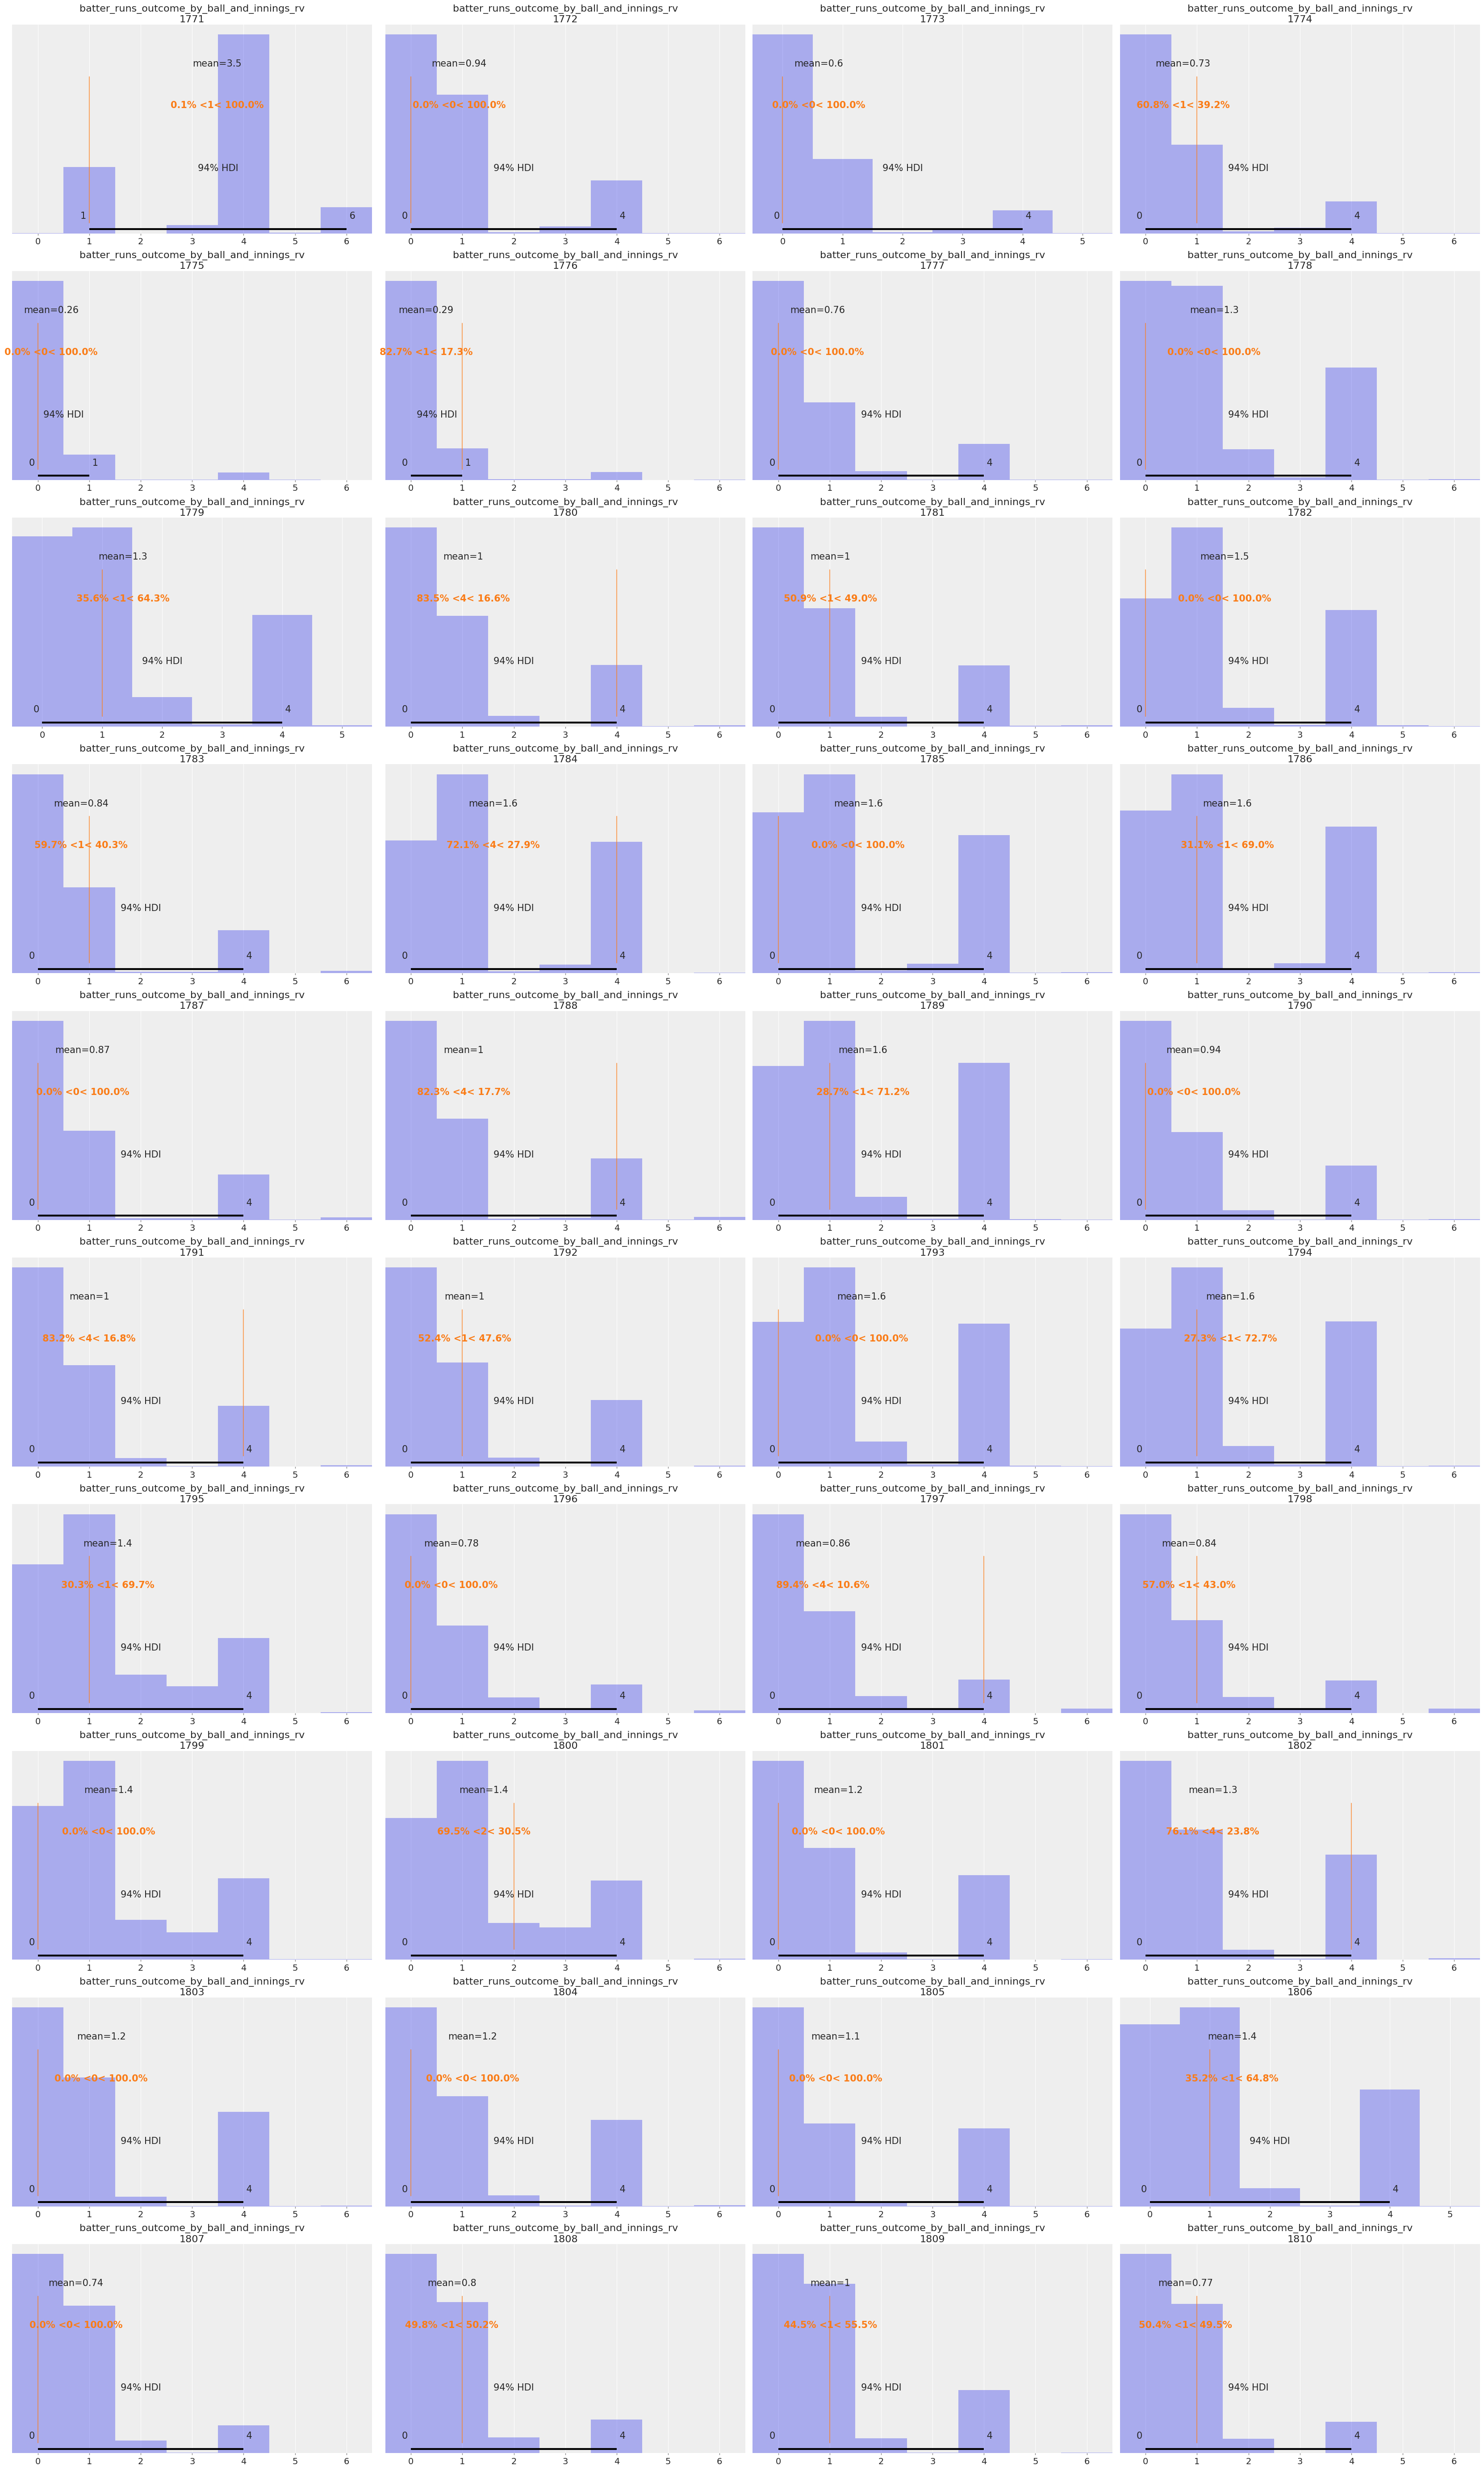

In [116]:
az.plot_posterior(
    idata.predictions,
    ref_val=test_combined_df.batter_runs.tolist(),
)

## Overall outcome distributions and beliefs

<AxesSubplot: >

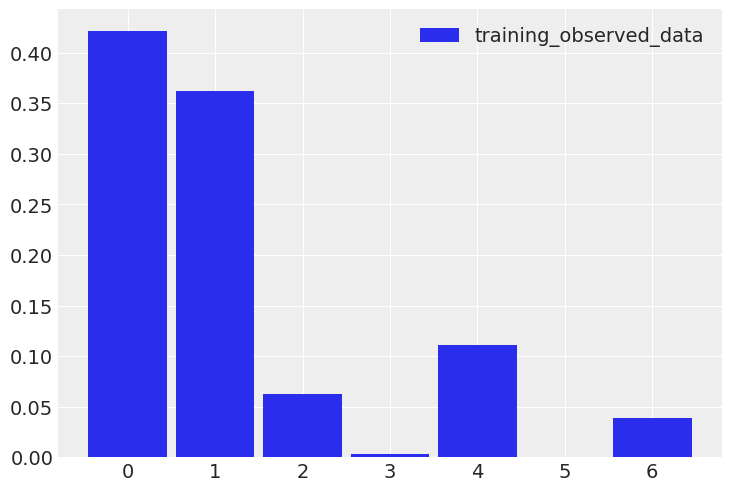

In [117]:
az.plot_dist(idata_loaded.observed_data["batter_runs_outcome_by_ball_and_innings_rv"], 
             color='C0', 
             label='training_observed_data')

<AxesSubplot: >

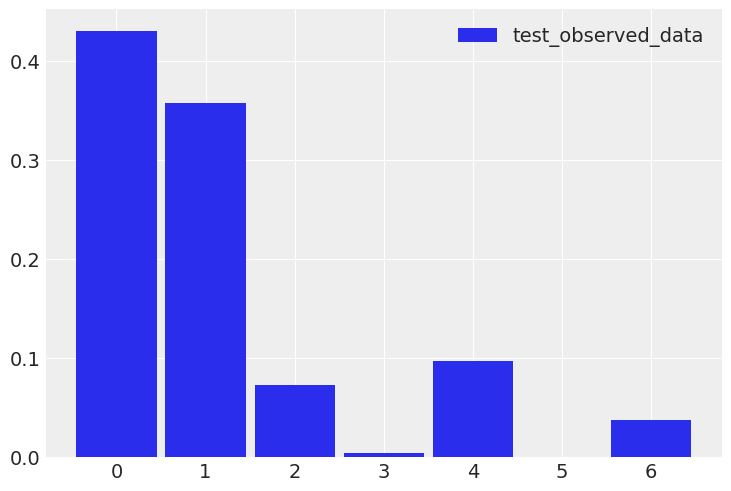

In [119]:
az.plot_dist(idata.predictions_constant_data["batter_runs_outcomes_data"], 
             color='C0', 
             label='test_observed_data')

<AxesSubplot: >

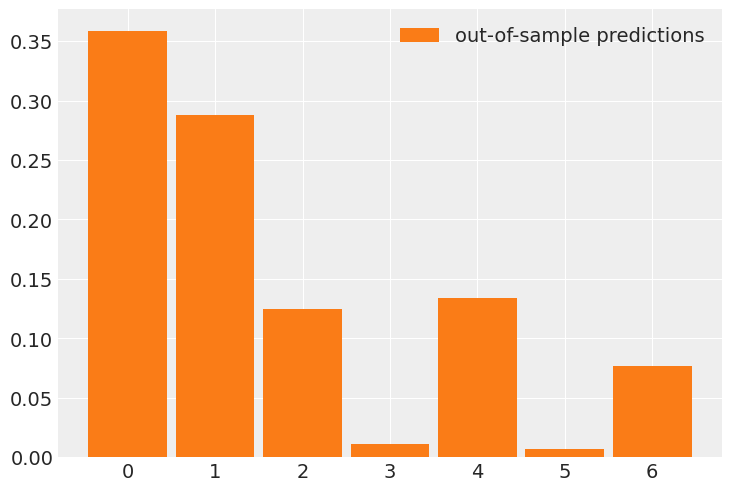

In [120]:
az.plot_dist(idata.predictions["batter_runs_outcome_by_ball_and_innings_rv"], 
             color='C1', 
             label = 'out-of-sample predictions')

## Outcome level model evaluation

In [121]:
def predictions_from_idata(idata,
                           var_name):
    preds_helper = lambda ds: ds.to_dataframe()[var_name].value_counts(normalize=True).to_xarray()
    predictions = (
        idata.predictions[var_name]
        .stack(dims=['chain','draw'])
        .groupby('ball_ids')
        .apply(preds_helper)
    )
    return predictions
    

In [122]:
predictions = predictions_from_idata(idata,
                                     'batter_runs_outcome_by_ball_and_innings_rv')

In [123]:
predictions_argmax = predictions.argmax('index')

In [124]:
predictions_max = predictions.max('index')

In [125]:
predictions_df = pd.DataFrame({'batter_runs':predictions_argmax.values,
                               'max':predictions_max.values})

In [126]:
from sklearn.metrics import classification_report, confusion_matrix
def print_cr_and_cm(true,pred):
    cr = classification_report(true,pred)
    cm = confusion_matrix(true,pred)
    print(cr)
    print(pd.DataFrame(cm))

In [127]:
print_cr_and_cm(test_combined_df.batter_runs,
                predictions_argmax)

              precision    recall  f1-score   support

           0       0.50      0.62      0.55      5859
           1       0.41      0.40      0.41      4861
           2       0.08      0.08      0.08       994
           3       0.00      0.00      0.00        60
           4       0.13      0.05      0.07      1321
           5       0.00      0.00      0.00         3
           6       0.06      0.04      0.05       508

    accuracy                           0.42     13606
   macro avg       0.17      0.17      0.17     13606
weighted avg       0.39      0.42      0.40     13606

      0     1    2  3    4  5    6
0  3608  1680  320  1  151  0   99
1  2239  1955  384  2  158  0  123
2   432   410   75  0   39  0   38
3    30    21    4  0    4  0    1
4   644   487   87  0   61  0   42
5     1     1    0  0    1  0    0
6   194   222   34  0   38  0   20


In [128]:
test_combined_no_idx = test_combined_df.reset_index()

## Is the model more accurate when it is more confident

In [129]:
def performance_for_idx(selection_idx,
                        prediction_df,
                        true_df):
    true_above_threshold = true_df.loc[selection_idx].batter_runs
    predicted_above_threshold = predictions_df.loc[selection_idx].batter_runs
    num_selected = selection_idx.sum()
    num_predicted = predictions_df.shape[0]
    pc_selected = num_selected*100/num_predicted
    print(f"\n{num_selected} selected out of {num_predicted}, selection pc = {pc_selected}")
    print_cr_and_cm(true_above_threshold,
                predicted_above_threshold)

In [130]:
## Check performance above threshold
def performance_above_threshold(threshold,
                                predictions_df,
                                true_df):
    above_threshold_idx = (predictions_df['max'] >= threshold)
    true_above_threshold = true_df.loc[above_threshold_idx].batter_runs
    predicted_above_threshold = predictions_df.loc[above_threshold_idx].batter_runs
    num_selected = above_threshold_idx.sum()
    num_predicted = predictions_df.shape[0]
    pc_selected = num_selected*100/num_predicted
    print(f"\n{num_selected} selected out of {num_predicted} at {threshold}, selection pc = {pc_selected}")
    print_cr_and_cm(true_above_threshold,
                predicted_above_threshold)


for threshold in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    performance_above_threshold(threshold,
                               predictions_df,
                               test_combined_no_idx)



13606 selected out of 13606 at 0.2, selection pc = 100.0
              precision    recall  f1-score   support

           0       0.50      0.62      0.55      5859
           1       0.41      0.40      0.41      4861
           2       0.08      0.08      0.08       994
           3       0.00      0.00      0.00        60
           4       0.13      0.05      0.07      1321
           5       0.00      0.00      0.00         3
           6       0.06      0.04      0.05       508

    accuracy                           0.42     13606
   macro avg       0.17      0.17      0.17     13606
weighted avg       0.39      0.42      0.40     13606

      0     1    2  3    4  5    6
0  3608  1680  320  1  151  0   99
1  2239  1955  384  2  158  0  123
2   432   410   75  0   39  0   38
3    30    21    4  0    4  0    1
4   644   487   87  0   61  0   42
5     1     1    0  0    1  0    0
6   194   222   34  0   38  0   20

12064 selected out of 13606 at 0.3, selection pc = 88.6667646626

In [131]:
from sklearn.metrics import jaccard_score
def calculate_overlap_for_batter_runs(target_runs,
                                      target_feature,
                                      predictions_df,
                                      true_df,
                                      k = 10):
    pred_idx = (predictions_df.batter_runs == target_runs)
    pred_top_k = true_df.loc[pred_idx][target_feature].value_counts(normalize=True).iloc[:k]
    #print(pred_top_k)
    true_idx = (true_df.batter_runs == target_runs)
    true_top_k = true_df.loc[true_idx][target_feature].value_counts(normalize=True).iloc[:k]
    inter = set(pred_top_k.index).intersection(true_top_k.index)
    #print(true_top_k)
    return len(inter)/k

## How many of the top 10 batters for a given outcome from the test dataset are in our predicted top 10

In [132]:
for target_runs in [0,1,2,4,6]:
    jc = calculate_overlap_for_batter_runs(target_runs,
                                           'batter_featured_id',
                                           predictions_df,
                                           test_combined_no_idx,
                                           k = 20)
    print(f'Score for {target_runs}: {jc}')

Score for 0: 0.7
Score for 1: 0.65
Score for 2: 0.45
Score for 4: 0.55
Score for 6: 0.3


## How many of the top 10 bowlers for a given outcome from the test dataset are in our predicted top 10

In [133]:
for target_runs in [0,1,2,4,6]:
    jc = calculate_overlap_for_batter_runs(target_runs,
                                           'bowler_featured_id',
                                           predictions_df,
                                           test_combined_no_idx,
                                           k = 20)
    print(f'Score for {target_runs}: {jc}')

Score for 0: 0.85
Score for 1: 0.7
Score for 2: 0.5
Score for 4: 0.5
Score for 6: 0.5


## Reporting performance clustered by the features we use

In [134]:
def performance_for_idx(selection_idx,
                        prediction_df,
                        true_df):
    true_above_threshold = true_df.loc[selection_idx].batter_runs
    predicted_above_threshold = predictions_df.loc[selection_idx].batter_runs
    num_selected = selection_idx.sum()
    num_predicted = predictions_df.shape[0]
    pc_selected = num_selected*100/num_predicted
    print(f"\n{num_selected} selected out of {num_predicted}, selection pc = {pc_selected}")
    print_cr_and_cm(true_above_threshold,
                predicted_above_threshold)

In [135]:
def performance_by_feature(predictions_df,
                           true_df,
                           feature_name):
    for feature,freq in true_df[feature_name].value_counts(normalize=True).to_dict().items():
        selected_idx = true_df[feature_name] == feature
        print(f"\n {feature_name} = {feature}, {freq}")
        performance_for_idx(selected_idx,
                            predictions_df,
                            true_df)

In [136]:
performance_by_feature(predictions_df,
                       test_combined_no_idx,
                       'over')


 over = 0, 0.05460826106129649

743 selected out of 13606, selection pc = 5.460826106129649
              precision    recall  f1-score   support

           0       0.74      0.93      0.82       480
           1       0.20      0.13      0.16       136
           2       0.20      0.03      0.06        29
           3       0.00      0.00      0.00         5
           4       0.10      0.05      0.07        79
           5       0.00      0.00      0.00         1
           6       0.33      0.08      0.12        13

    accuracy                           0.63       743
   macro avg       0.22      0.17      0.18       743
weighted avg       0.54      0.63      0.57       743

     0   1  2  3   4  5  6
0  444  24  1  0  10  0  1
1   99  18  1  0  17  0  1
2   19   6  1  0   3  0  0
3    2   1  1  0   1  0  0
4   38  36  1  0   4  0  0
5    0   0  0  0   1  0  0
6    1   7  0  0   4  0  1

 over = 1, 0.0541672791415552

737 selected out of 13606, selection pc = 5.41672791415552
   

In [137]:
performance_by_feature(predictions_df,
                       test_combined_no_idx,
                       'inning')


 inning = 0, 0.5160223430839336

7021 selected out of 13606, selection pc = 51.602234308393356
              precision    recall  f1-score   support

           0       0.49      0.61      0.54      2938
           1       0.42      0.40      0.41      2569
           2       0.08      0.08      0.08       525
           3       0.00      0.00      0.00        33
           4       0.12      0.04      0.05       682
           5       0.00      0.00      0.00         2
           6       0.06      0.06      0.06       272

    accuracy                           0.41      7021
   macro avg       0.17      0.17      0.16      7021
weighted avg       0.38      0.41      0.39      7021

      0     1    2  3   4  5   6
0  1787   823  192  0  63  0  73
1  1165  1019  222  0  77  0  86
2   238   201   42  0  17  0  27
3    16    11    3  0   3  0   0
4   326   243   56  0  24  0  33
5     1     0    0  0   1  0   0
6   100   118   20  0  19  0  15

 inning = 1, 0.4831691900632074

6574 sele

In [138]:
performance_by_feature(predictions_df,
                       test_combined_no_idx,
                       'venue')


 venue = 2, 0.2677495222695869

3643 selected out of 13606, selection pc = 26.774952226958696
              precision    recall  f1-score   support

           0       0.51      0.60      0.55      1560
           1       0.42      0.43      0.43      1343
           2       0.06      0.08      0.07       238
           3       0.00      0.00      0.00        11
           4       0.17      0.04      0.07       361
           6       0.12      0.02      0.04       130

    accuracy                           0.43      3643
   macro avg       0.21      0.20      0.19      3643
weighted avg       0.40      0.43      0.40      3643

     0    1    2  3   4  5
0  931  484  108  0  32  5
1  608  582  122  0  23  8
2  104  105   19  0   6  4
3    6    4    0  0   1  0
4  155  147   38  0  15  6
5   36   70   11  0  10  3

 venue = 7, 0.2106423636630898

2866 selected out of 13606, selection pc = 21.064236366308982
              precision    recall  f1-score   support

           0       0.50

## Calculate % of scenarios for each ball where prediction is accurate

In [139]:
def get_match_scenario_pc(ds):
    ball_id = ds.ball_ids.values
    num_matching_scenarios = (ds == test_combined_no_idx.iloc[ball_id-train_combined_df.shape[0]].batter_runs).sum()
    matching_scenarios_pc = num_matching_scenarios/4000
    #print(f"{num_matching_scenarios.values} scenarios, {matching_scenarios_pc.values} for {ball_id}")
    return matching_scenarios_pc

In [140]:
matching_scenario_pc_by_ball = (
    idata.predictions['batter_runs_outcome_by_ball_and_innings_rv']
    .groupby('ball_ids')
    .apply(get_match_scenario_pc)
)

In [141]:
matching_scenario_pc_by_batting_runs = pd.DataFrame({'matching_scenario_pc': matching_scenario_pc_by_ball.values,
                                                     'batter_runs': test_combined_df.batter_runs,
                                                     'batter_featured_id':test_combined_df.batter_featured_id.values,
                                                     'bowler_featured_id':test_combined_df.bowler_featured_id.values,
                                                     'venue': test_combined_df.venue.values,
                                                     'is_legal_delivery': test_combined_df.is_legal_delivery.values,
                                                     'over': test_combined_no_idx.over.values,
                                                     'inning': test_combined_no_idx.inning.values,
                                                     'match': test_combined_no_idx.match_key.values,
                                                     'is_wicket': test_combined_no_idx.is_wicket.values,
                                                     'innings_strike_rate': test_combined_no_idx.innings_strike_rate.values})

In [142]:
COORDS['batter_runs']

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')

<AxesSubplot: xlabel='batter_runs', ylabel='matching_scenario_pc'>

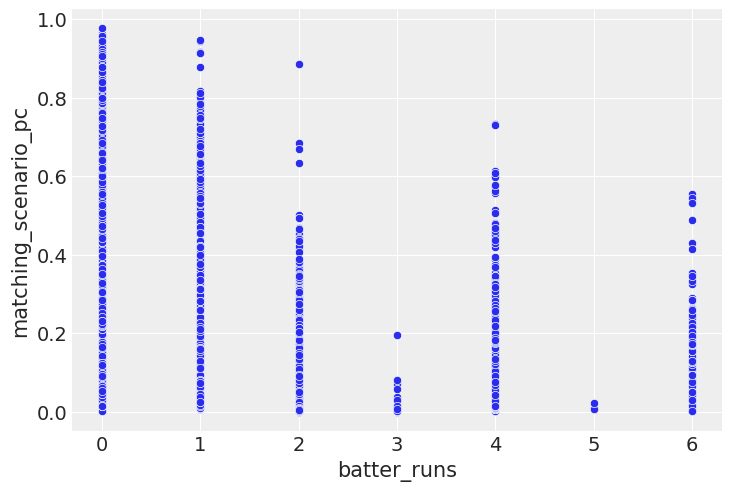

In [143]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'batter_runs',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='venue', ylabel='matching_scenario_pc'>

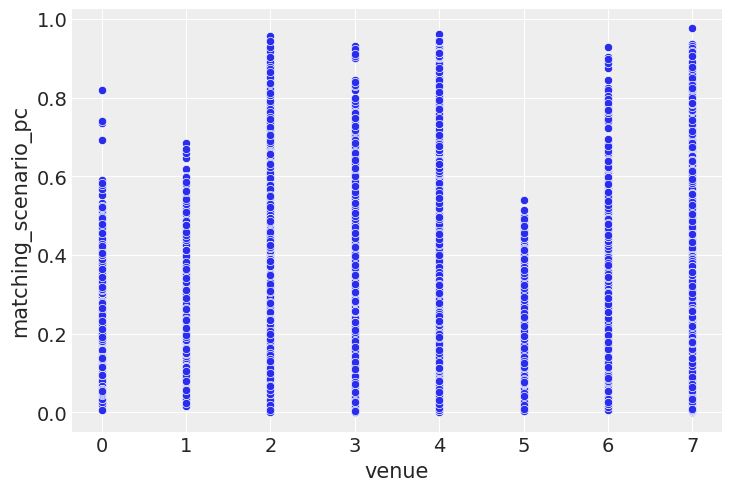

In [144]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'venue',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='over', ylabel='matching_scenario_pc'>

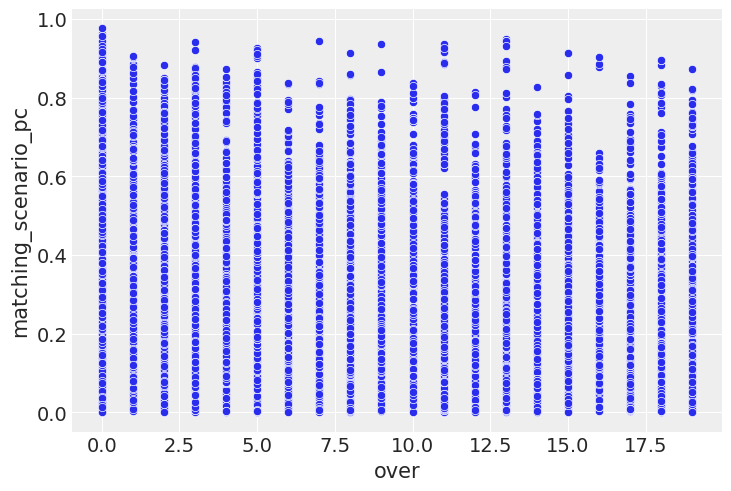

In [145]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'over',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='inning', ylabel='matching_scenario_pc'>

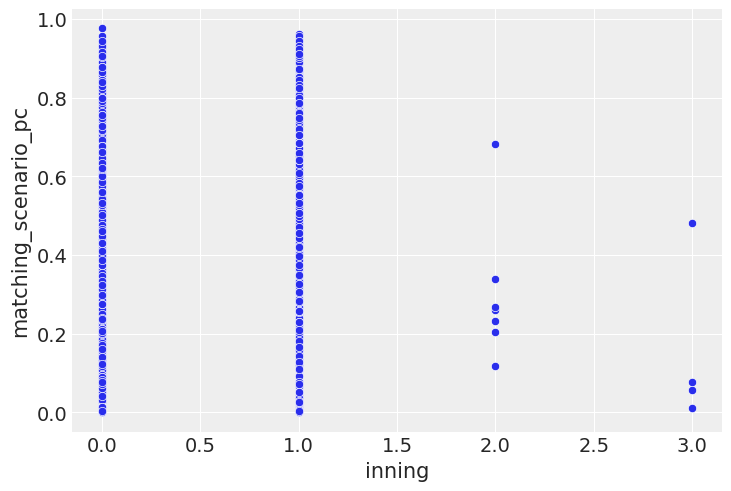

In [146]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'inning',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='is_wicket', ylabel='matching_scenario_pc'>

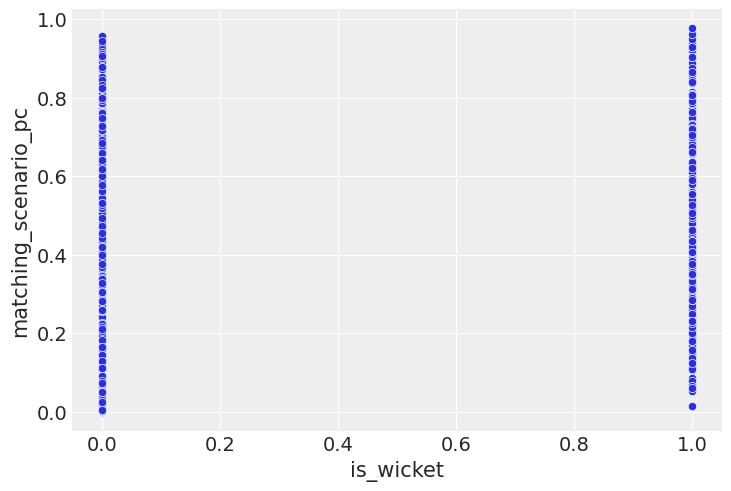

In [147]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'is_wicket',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='batter_featured_id', ylabel='matching_scenario_pc'>

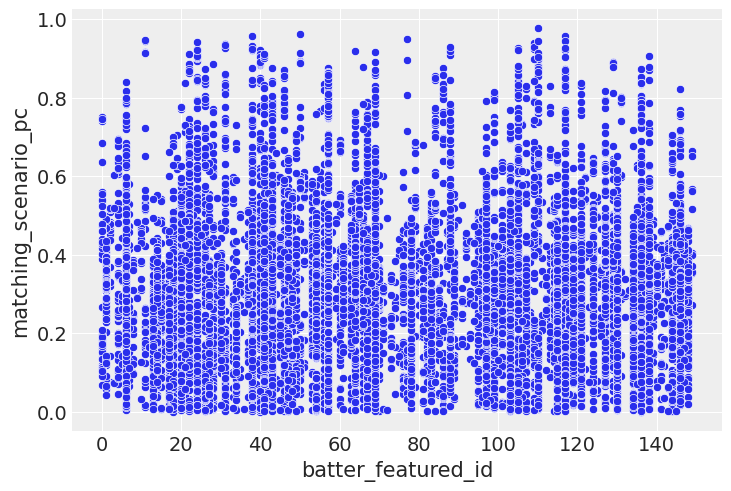

In [148]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'batter_featured_id',
    y = 'matching_scenario_pc'
)

<AxesSubplot: xlabel='bowler_featured_id', ylabel='matching_scenario_pc'>

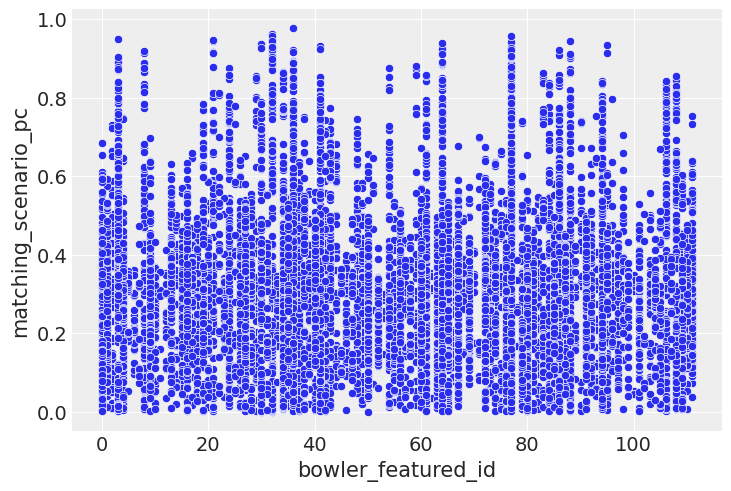

In [149]:
sns.scatterplot(
    data = matching_scenario_pc_by_batting_runs,
    x = 'bowler_featured_id',
    y = 'matching_scenario_pc'
)

## Try traditional ML with OHE

In [150]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoders = {}
train_ohe_features = {}
test_ohe_features = {}

In [151]:
for feature in ['batter','bowler','venue','over','inning','wickets_fallen']:
    ohe = OneHotEncoder(sparse=False)
    all_features = pd.concat([train_match_state_df[[feature]],
                             test_season_match_state_df[[feature]]])
    ohe.fit(all_features)
    train_features = ohe.transform(train_match_state_df[[feature]])
    test_features = ohe.transform(test_season_match_state_df[[feature]])
    one_hot_encoders[feature] = ohe
    train_ohe_features[feature] = train_features
    test_ohe_features[feature] = test_features

In [152]:
for feature in ['innings_strike_rate']:
    train_ohe_features[feature] = train_match_state_df[[feature]].values
    test_ohe_features[feature] = test_season_match_state_df[[feature]].values

In [153]:
train_ohe_feature_array = np.hstack([v[1] for v in train_ohe_features.items()])
test_ohe_feature_array = np.hstack([v[1] for v in test_ohe_features.items()])

In [154]:
train_ohe_feature_array.shape

(1771, 306)

In [155]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(train_ohe_feature_array,
        train_bowling_outcomes_df['batter_runs'])

RandomForestClassifier()

In [156]:
predictions_rfc = clf.predict(test_ohe_feature_array)

In [157]:
predictions_rfc_df = pd.DataFrame({'batter_runs': predictions_rfc})

<AxesSubplot: >

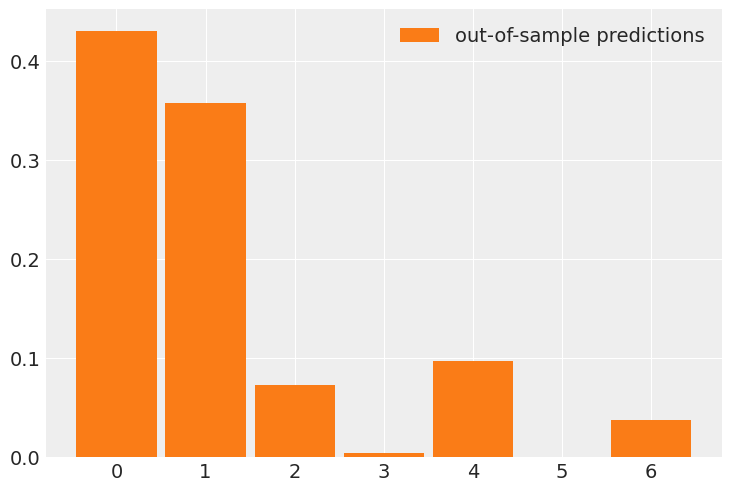

In [158]:
az.plot_dist(test_season_bowling_outcomes_df.batter_runs, 
             color='C1', 
             label = 'out-of-sample predictions')

<AxesSubplot: >

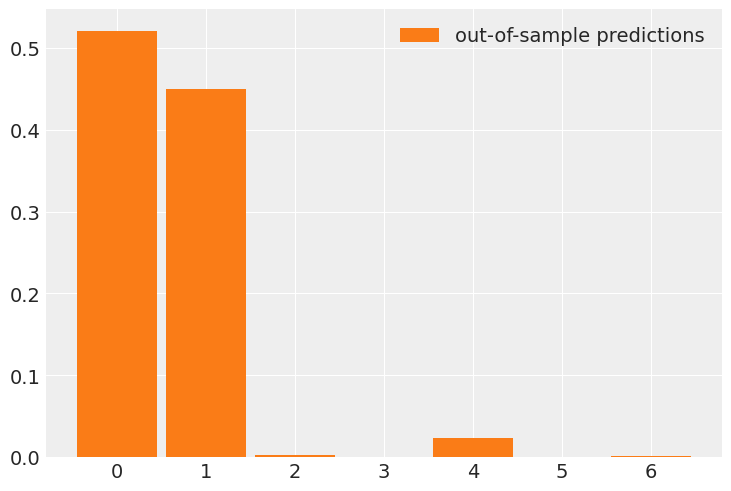

In [159]:
az.plot_dist(predictions_rfc_df.batter_runs, 
             color='C1', 
             label = 'out-of-sample predictions')

In [160]:
for target_runs in [0,1,2,4,6]:
    jc = calculate_overlap_for_batter_runs(target_runs,
                                           'batter_featured_id',
                                           predictions_rfc_df,
                                           test_combined_no_idx,
                                           k = 20)
    print(f'Score for {target_runs}: {jc}')

Score for 0: 0.95
Score for 1: 0.75
Score for 2: 0.35
Score for 4: 0.5
Score for 6: 0.25


In [161]:
for target_runs in [0,1,2,4,6]:
    jc = calculate_overlap_for_batter_runs(target_runs,
                                           'bowler_featured_id',
                                           predictions_rfc_df,
                                           test_combined_no_idx,
                                           k = 20)
    print(f'Score for {target_runs}: {jc}')

Score for 0: 0.9
Score for 1: 0.8
Score for 2: 0.35
Score for 4: 0.4
Score for 6: 0.25


In [162]:
print_cr_and_cm(test_combined_df.batter_runs,
                predictions_rfc)

              precision    recall  f1-score   support

           0       0.50      0.61      0.55      5859
           1       0.42      0.53      0.47      4861
           2       0.58      0.03      0.05       994
           3       0.50      0.03      0.06        60
           4       0.28      0.07      0.11      1321
           5       0.00      0.00      0.00         3
           6       0.52      0.03      0.05       508

    accuracy                           0.46     13606
   macro avg       0.40      0.19      0.19     13606
weighted avg       0.46      0.46      0.42     13606

      0     1   2  3    4  5   6
0  3577  2161   8  2  106  0   5
1  2173  2595   6  0   80  0   7
2   438   516  26  0   14  0   0
3    33    23   0  2    1  0   1
4   644   586   2  0   89  0   0
5     1     1   0  0    1  0   0
6   224   242   3  0   25  0  14
